In [1]:
import ROOT
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import glob
%jsroot
from tqdm import tqdm
from array import array
import itertools
from collections import defaultdict
from collections import Counter
import pandas as pd
import random
import pickle

import scipy.stats as stats
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from scipy.spatial import KDTree
from matplotlib.lines import Line2D

import torch
from torch.utils.data import Dataset
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
from torch_geometric.nn import DynamicEdgeConv, TransformerConv, Set2Set, GlobalAttention
from torch_geometric.utils import to_dense_batch, dense_to_sparse
from torch_geometric.data import Batch
from torch.nn import Sequential, Linear, ReLU
from torch_cluster import radius_graph
from torch_geometric.nn import knn_graph
import torch.nn.functional as F
from math import acos, degrees

from torch import nn
from torch_geometric.nn import (
    DynamicEdgeConv,
    GATConv,
    global_mean_pool,
    knn_graph
)
from torch_geometric.utils import to_dense_batch
import matplotlib.patches as mpatches
from torch.optim.lr_scheduler import StepLR,ReduceLROnPlateau
from torch_geometric.nn import JumpingKnowledge

Welcome to JupyROOT 6.30/04


In [2]:
layout_file = ROOT.TFile("/mnt/e/testML/pie/run00000-00.root")
geohelper = layout_file.Get("PIMCGeoHelper")
layout = geohelper.GetLayout("CALORIMETER", "TP2")

In [3]:
pdg_to_idx = {pdg: i for i, pdg in enumerate([211,-13,-11,11,98105])}
# Bitmask constants (1 bit per particle type)
PION      = 0b00001  # 1
MUON      = 0b00010  # 2
POSITRON  = 0b00100  # 4
ELECTRON  = 0b01000  # 8
OTHER     = 0b10000  # 16

def pdg_to_mask(pdg_id):
    if pdg_id == 211: return PION
    elif pdg_id == -13: return MUON
    elif pdg_id == -11:       return POSITRON
    elif pdg_id == 11:        return ELECTRON
    else:                     return OTHER

MASK_TO_PDG = {
    0b00001: 211,    # pion
    0b00010: -13,     # muon
    0b00100: -11,    # positron
    0b01000: 11,     # electron
    0b10000: 98105    # other
    }

def decode_mask(mask):
    """
    Given a bitmask, return a list of PDG IDs it represents.
    """
    return [pdg for bit, pdg in MASK_TO_PDG.items() if mask & bit]

In [4]:
def smear(energy,energy_resolution):
    stdv = energy * energy_resolution
    smeared_energy = energy + np.random.normal(0,stdv)
    return smeared_energy

bounds = {
    "x": (-10.0, 10.0),
    "y": (-10.0, 10.0),
    "z": (0.0, 6.6),
}

def normalize(val, minv, maxv):
    return 2 * (val - minv) / (maxv - minv) - 1

In [5]:
MERGE_WINDOW = 2
GROUP_WINDOW = 1
def group_hits_in_time(allHits, time_window_ns=GROUP_WINDOW):
    """
    Groups hits into clusters where each hit is within `time_window_ns`
    of the first hit in the group.

    Parameters:
        allHits: dict mapping pixelID -> list of np.array hits
                 where each hit is [x/y, z, stripType, energy, time, pdg, eventNum]
        time_window_ns: max allowed time separation within a group

    Returns:
        List of groups, where each group is a list of np.ndarray hits (no pixelID)
    """
    # Flatten all hits into a list of hit_array
    hit_list = []
    for hits in allHits.values():
        hit_list.extend(hits)

    # Sort hits by time (index 4)
    hit_list.sort(key=lambda hit: hit[4])

    #print(len(allHits), len(hit_list), "hits in total")

    groups = []
    current_group = []
    group_time = None

    for hit in hit_list:
        time = hit[4]
        if not current_group:
            current_group.append(hit)
            group_time = time
        elif abs(time - group_time) <= time_window_ns:
            current_group.append(hit)
            group_time = time
        else:
            total_energy = sum(h[3] for h in current_group)
            group_with_energy = [np.append(h, total_energy/1) for h in current_group]
            random.shuffle(group_with_energy)
            groups.append(np.array(group_with_energy))
            #random.shuffle(current_group)
            #groups.append(np.array(current_group))
            current_group = [hit]
            group_time = time

    if current_group:
        total_energy = sum(h[3] for h in current_group)
        group_with_energy = [np.append(h, total_energy/1) for h in current_group]
        random.shuffle(group_with_energy)
        groups.append(np.array(group_with_energy))
        #random.shuffle(current_group)
        #groups.append(np.array(current_group))
    #print([print(group) for group in groups])

    return groups

In [6]:
def groupID(groupList):
    """
    This function takes in a list of groups of hits, and returns the unique PDG IDs
    associated with each group, based on bitmask encoding. A PDG ID is kept only if it
    appears in at least two hits in the group; if none do, all are kept.
    """
    unique_pdg_per_group = []

    for group in groupList:
        all_decoded_pdgs = []
        for hit in group:
            mask = int(hit[5])
            all_decoded_pdgs.extend(decode_mask(mask))

        pdg_counts = Counter(all_decoded_pdgs)
        unique_pdgs = [pdg for pdg, count in pdg_counts.items() if count >= 2]

        if not unique_pdgs:
            unique_pdgs = list(pdg_counts.keys())

        unique_pdg_per_group.append(unique_pdgs)

    return unique_pdg_per_group

In [7]:
def groupMerger(groupList, prob=1.0):
    if len(groupList) != 3:
        return groupList

    if random.random() < prob:
        start_idx = random.choice([0, 1])
        idx1, idx2 = start_idx, start_idx + 1

        group1 = groupList[idx1]
        group2 = groupList[idx2]

        merged_dict = {}

        # Collect all hits from both groups
        for hit in np.concatenate((group1, group2)):
            # Define unique position key
            key = (hit[0], hit[1], int(hit[2]))  # (coord, z, stripType)

            if key not in merged_dict:
                merged_dict[key] = hit.copy()
            else:
                existing_hit = merged_dict[key]
                existing_hit[3] += hit[3]  # merge energy
                existing_hit[4] = min(existing_hit[4], hit[4])  # keep earliest time
                existing_hit[5] = int(existing_hit[5]) | int(hit[5])  # merge pdg bitmasks

        # Final merged array
        merged = np.array(list(merged_dict.values()))
        np.random.shuffle(merged)

        # Replace original groups
        for idx in sorted([idx1, idx2], reverse=True):
            groupList.pop(idx)
        groupList.insert(idx1, merged)

    return groupList

In [16]:
kPidif  = 0x0000000010
def process_time_groups(sample_chains, max_events=10000, geohelper=geohelper, enhanceMerge=False, pionstop=True, positronAngle=False):
    """
    Processes sample chains to extract time-grouped hits and their labels per event.

    Parameters:
        sample_chains (dict): Mapping of run -> TChain or iterable of entries.
        geohelper: Geometry helper with GetX/Y/Z and GetPsi methods.
        smear (func): Smearing function that takes (energy, resolution).
        group_hits_in_time (func): Function to time-group hits.
        groupID (func): Function to generate group labels from time groups.
        max_events_per_chain (int): Max number of events to process per run.

    Returns:
        eventTimeGroups (dict): Mapping event index -> grouped hit arrays.
        timeGroupLabels (dict): Mapping event index -> group label list.
    """
    MERGE_WINDOW = 2
    eventTimeGroups = np.empty(max_events, dtype=object)
    timeGroupLabels = np.empty(max_events, dtype=object)
    if pionstop:
        pionStops = np.empty(max_events, dtype=object)
    if positronAngle:
        positronAngles = np.empty(max_events, dtype=object)

    eventNumber = 0

    events_per_chain = max_events // len(sample_chains)

    for run, chain in tqdm(sample_chains.items()):
        events_taken = 0

        triggered = 0
        
        for entry in chain:

            if events_taken >= events_per_chain or eventNumber >= max_events:
                break

            eventType = int(entry.info.GetType())
            if eventType & kPidif:
                # Skip events that are of type kPidif
                continue
                
            allHits = {}

            triggered = 0
            for upstream in entry.upstream:
                if upstream.GetUpstreamID() == 99999:
                    energyDTAR = upstream.GetTotalEnergyDeposit()
                    if energyDTAR > 1:
                        triggered = 1
                    
            if not triggered:
                eventTimeGroups[eventNumber] = []
                timeGroupLabels[eventNumber] = []
                if pionstop:
                    pionStops[eventNumber] = []
                if positronAngle:
                    positronAngles[eventNumber] = []
                continue

            pion_in_atar = 0
            pion_stop_position = (-100, -100, -100)
            pion_time = 0

            thetaInit, phiInit = -1000, -1000
            positron_in_atar = 0

            evil_event= 0

            merged_pdgs_counter = {}
            merged_pixels = []

            for decay in entry.decay:
                nD = decay.GetNDaughters()
                if run == 'michel':
                    if nD != 3:
                        breaker = 1
                        continue
                    if (nD == 3):
                        #decayTime = decay.GetTime()
                        #truthMom = mom.R()
                        #truthEnergy = np.sqrt((ELECTRON_MASS ** 2) + truthMom**2) + ELECTRON_MASS
                        mom = decay.GetDaughterMomAt(2)
                        #pdg = decay.GetDaughterPDGIDAt(2)
                        thetaInit = mom.Theta()
                        phiInit = mom.Phi()
                        continue
                elif run == 'pie':
                    if nD != 2:
                        breaker = 1
                        continue
                    if (nD == 2):
                        #decayTime = decay.GetTime()
                        #truthMom = mom.R()
                        #truthEnergy = np.sqrt((ELECTRON_MASS ** 2) + truthMom**2) + ELECTRON_MASS
                        mom = decay.GetDaughterMomAt(1)
                        #pdg = decay.GetDaughterPDGIDAt(1)
                        thetaInit = mom.Theta()
                        phiInit = mom.Phi()
                        continue
            
            for atarHit in entry.atar:
                pdg = atarHit.GetPDGID()
                if pdg not in [211, -11, -13,11]:
                    continue
            
                if pdg not in [211,-11,-13,11]:
                    print('evil')
                    evil_event = 1

                pdg_binary = pdg_to_mask(pdg)

                true_time = atarHit.GetTime()
                hitTime = true_time + np.random.normal(0, 0.2)
                pixelID = atarHit.GetPixelID()
                edep = atarHit.GetEdep()
                energySmeared = smear(edep, 0.15)
                stripType = abs(abs(geohelper.GetPsi(pixelID)) - 0.0) > 0.01

                coord = geohelper.GetY(pixelID) if stripType else geohelper.GetX(pixelID)
                z = geohelper.GetZ(pixelID)

                truePositions = [atarHit.GetX1(),atarHit.GetY1(),atarHit.GetZ1()]

                hit = np.array([coord, z, stripType, energySmeared, hitTime, pdg_binary, eventNumber, truePositions[0], truePositions[1], truePositions[2], true_time])

                if pdg == 211:
                    pion_in_atar = 1
                    if pionstop:
                        if atarHit.GetTime() > pion_time:
                            pion_time = atarHit.GetTime()
                            pion_stop_position = ((atarHit.GetX0()+atarHit.GetX1())/2, (atarHit.GetY0()+atarHit.GetY1())/2, (atarHit.GetZ0()+atarHit.GetZ1())/2)

                if pdg == -11:
                    positron_in_atar = 1


                if pixelID in allHits:
                    merged = False
                    for existing_hit in allHits[pixelID]:
                        if abs(existing_hit[4] - hitTime) < MERGE_WINDOW:
                            existing_hit[3] += energySmeared
                            existing_hit[5] = int(existing_hit[5]) | int(pdg_binary)
                            if pixelID not in merged_pixels:
                                merged_pixels.append(pixelID)
                            merged = True
                            break
                    if not merged:
                        allHits[pixelID].append(hit)
                else:
                    allHits[pixelID] = [hit]

            if len(allHits) < 10:
                evil_event = 1

            if ((not pion_in_atar) or evil_event or (not positron_in_atar)):
                eventTimeGroups[eventNumber] = []
                timeGroupLabels[eventNumber] = []
                if pionstop:
                    pionStops[eventNumber] = []
                if positronAngle:
                    positronAngles[eventNumber] = []
                continue
            
            #if len(allHits) > 200:
            #    print(len(allHits), "hits in event", eventNumber, "run", run)

            # Time-grouping
            groups = group_hits_in_time(allHits)

            #for group in groups:
            #    if len(group) > 200:
            #        print(len(group), "hits in group", eventNumber, "run", run)
                
            if enhanceMerge:
                groups = groupMerger(groups,1.0)

            groupLabels = groupID(groups)

            eventTimeGroups[eventNumber] = groups
            timeGroupLabels[eventNumber] = groupLabels
            if pionstop:
                pionStops[eventNumber] = pion_stop_position
            if positronAngle:
                positronAngles[eventNumber] = [thetaInit, phiInit]

            events_taken += 1
            eventNumber += 1

    # Find indices of empty events
    empty_indices = [i for i, groups in enumerate(eventTimeGroups) if len(groups) == 0]
    
    # Convert to NumPy arrays with object dtype to allow deletion by index
    eventTimeGroupsCleaned = np.array(eventTimeGroups, dtype=object)
    timeGroupLabelsCleaned = np.array(timeGroupLabels, dtype=object)
    pionStopsCleaned = np.array(pionStops, dtype=object) if pionstop else None
    positronAnglesCleaned = np.array(positronAngles, dtype=object) if positronAngle else None
    eventIndexCleaned = np.array(list(range(max_events)))
    
    # Remove empty events
    eventTimeGroupsCleaned = np.delete(eventTimeGroupsCleaned, empty_indices)
    timeGroupLabelsCleaned = np.delete(timeGroupLabelsCleaned, empty_indices)
    eventIndexCleaned = np.delete(eventIndexCleaned, empty_indices)
    pionStopsCleaned = np.delete(pionStopsCleaned, empty_indices) if pionstop else None
    positronAnglesCleaned = np.delete(positronAnglesCleaned, empty_indices) if positronAngle else None

    flat_arr = []
    group_index_dict = {}
    
    for event_idx, event in enumerate(timeGroupLabelsCleaned):
        for group_idx, group in enumerate(event):
            flat_arr.append(group)
            flat_index = len(flat_arr) - 1
            group_index_dict[flat_index] = (event_idx, group_idx)

    if pionstop and not positronAngle:
        return eventTimeGroupsCleaned, timeGroupLabelsCleaned, eventIndexCleaned, group_index_dict, pionStopsCleaned
    elif positronAngle:
        return eventTimeGroupsCleaned, timeGroupLabelsCleaned, eventIndexCleaned, group_index_dict, pionStopsCleaned, positronAnglesCleaned
    else:
        return eventTimeGroupsCleaned, timeGroupLabelsCleaned, eventIndexCleaned, group_index_dict

In [17]:
class EndpointsDataset(Dataset):
    def __init__(self, event_group):
        self.groups = event_group

    def __len__(self):
        return len(self.groups)

    def __getitem__(self, idx):
        group = np.array(self.groups[idx])
        coords = group[:, 0]
        zs = group[:, 1]
        strip_types = group[:, 2].astype(int)
        energy = group[:, 3]
        times = group[:, 4]
        pdgs = group[:, 5].astype(int)
        event_number = group[:, 6]
        true_x = group[:, 7]
        true_y = group[:, 8]
        true_z = group[:, 9]
        true_time = group[:, 10]
        group_energy = group[:, 11]

        # Feature construction
        view0 = (strip_types == 0).astype(float)
        view1 = (strip_types == 1).astype(float)

        x = torch.tensor(np.stack([coords, zs, energy, view0, view1, group_energy], axis=1), dtype=torch.float)

        event_id = torch.tensor(event_number, dtype=torch.int)
        most_common_pdg = Counter(pdgs).most_common(1)[0][0]
        if most_common_pdg == 11:
            most_common_pdg = -11
        group_type = torch.tensor(most_common_pdg, dtype=torch.int)

        mask = pdgs == most_common_pdg
        filtered_times = true_time[mask]
        filtered_x = true_x[mask]
        filtered_y = true_y[mask]
        filtered_z = true_z[mask]

        start,stop = np.argmin(filtered_times), np.argmax(filtered_times)
        start_raw, stop_raw = [filtered_x[start],filtered_y[start],filtered_z[start]], [filtered_x[stop],filtered_y[stop],filtered_z[stop]]
        start_pos, stop_pos = torch.tensor(start_raw, dtype=torch.float), torch.tensor(stop_raw, dtype=torch.float)
        y = torch.stack([start_pos, stop_pos], dim=0).unsqueeze(0)

        return Data(x=x, y=y, event_id=event_id, group_type=group_type)

In [18]:
class FullTransformerBlock(nn.Module):
    def __init__(self, hidden_channels, heads, dropout):
        super().__init__()
        self.attn = TransformerConv(
            in_channels=hidden_channels,
            out_channels=hidden_channels // heads,
            heads=heads,
            dropout=dropout,
            concat=True,
            beta=True,
            edge_dim=4
        )
        self.norm1 = nn.LayerNorm(hidden_channels)
        self.ffn = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels * 4),
            nn.ReLU(),
            nn.Linear(hidden_channels * 4, hidden_channels)
        )
        self.norm2 = nn.LayerNorm(hidden_channels)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index, edge_attr=None):
        y = self.attn(x, edge_index, edge_attr)
        x = self.norm1(x + self.dropout(y))
        y2 = self.ffn(x)
        x = self.norm2(x + self.dropout(y2))
        return x



In [19]:
class EndpointFinderGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, heads=4,num_blocks=2, dropout=0.2):
        super().__init__()
        self.lin_embed = nn.Linear(in_channels, hidden_channels)
        self.blocks = nn.ModuleList([
            FullTransformerBlock(hidden_channels, heads, dropout) for _ in range(num_blocks)
        ])

        self.jk_layer = JumpingKnowledge(mode='cat')
        jk_output_channels = hidden_channels * num_blocks

        self.regressor = nn.Sequential(
            nn.Linear(jk_output_channels + 1, hidden_channels * 2),
            nn.ReLU(),
            nn.Linear(hidden_channels * 2, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 6)
        )
        self.pool = GlobalAttention(
            gate_nn=torch.nn.Sequential(
                nn.Linear(jk_output_channels, 64),
                nn.ReLU(),
                nn.Linear(64, 1)
            )
        )

    def forward(self, data):
        x_raw = data.x
        x = self.lin_embed(x_raw)         # shape: [N, hidden_channels]
        batch = data.batch                # shape: [N]

        pos2d = x_raw[:, :2]              # [coord, z]
        energy = x_raw[:, 2]
        view0, view1 = x_raw[:, 3], x_raw[:, 4]
        
        # Use to_dense_batch to get a padded representation and a mask
        # We only need the mask, so we can use a small tensor like batch for efficiency
        _, mask = to_dense_batch(data.batch, data.batch) # mask shape: [B, N_max]
        B, N_max = mask.shape

        # --- Build Adjacency Matrix in the Dense space ---
        # Create a fully-connected adjacency matrix for each graph in the batch
        adj = torch.ones(B, N_max, N_max, device=x.device)

        # Mask out connections from/to padding nodes so they are not included
        adj.masked_fill_(~mask.unsqueeze(1), 0)
        adj.masked_fill_(~mask.unsqueeze(2), 0)

        # Remove self-loops (a node doesn't have an edge to itself)
        adj.diagonal(dim1=-2, dim2=-1).fill_(0)

        # --- Map Dense Edges back to Sparse Indices ---
        # Find the coordinates of all existing edges in the dense batch: (batch_idx, local_row, local_col)
        b, i, j = adj.nonzero(as_tuple=True)

        # To map these back to the original 'x_raw' tensor, we need a cumulative sum of event sizes.
        # This gives us the starting index for each event in the original flat tensor.
        unique_batches, counts = torch.unique(data.batch, return_counts=True)
        cumsum = torch.cat([counts.new_zeros(1), counts.cumsum(dim=0)])

        # Calculate the final 'edge_index' in the sparse (global) space
        # global_row = start_of_event_in_x_raw + local_row_in_event
        row = cumsum[b] + i
        col = cumsum[b] + j
        edge_index = torch.stack([row, col], dim=0)
        #ed2 = edge_index

        #ed1_sorted = ed1[:, ed1[0].argsort()]
        #ed2_sorted = ed2[:, ed2[0].argsort()]

        #assert torch.equal(ed1_sorted, ed2_sorted), \
        #    "Edge indices do not match after conversion from dense to sparse!"

        num_nodes = x_raw.size(0)
        assert edge_index.max().item() < num_nodes, \
        f"Index out of bounds! Max generated index is {edge_index.max().item()}, but there are only {num_nodes} nodes."

        # --- Build Edge Attributes using the CORRECT sparse indices ---
        # This section is now safe because 'row' and 'col' are valid indices for x_raw
        pos2d = x_raw[:, :2]
        delta = pos2d[col] - pos2d[row]  # shape: [E, 2]

        energy = x_raw[:, 2]
        dE = (energy[col] - energy[row]).unsqueeze(1)  # [E, 1]

        view0, view1 = x_raw[:, 3], x_raw[:, 4]
        same_view = ((view0[col] * view0[row]) + (view1[col] * view1[row])).unsqueeze(1)  # [E, 1]

        edge_attr = torch.cat([delta, dE, same_view], dim=1)  # [E, 4]

        # Transformer blocks (supporting edge_attr now)
        layer_outputs = []
        for block in self.blocks:
            x = block(x, edge_index, edge_attr)
            layer_outputs.append(x)

        # Jumping Knowledge Layer
        xjk = self.jk_layer(layer_outputs)  # shape: [num_groups, hidden_channels * num_blocks]
        # Pooling to get group representations
        x_group = self.pool(xjk, batch)  # shape: [num_groups, hidden_channels * num_blocks]

        # Append group classification
        group_type = data.group_type.unsqueeze(1).float()  # shape: [num_groups, 1]
        x_group_comb = torch.cat([x_group, group_type], dim=1)


        return self.regressor(x_group_comb).view(-1, 2, 3) # [batch_size, 2, 3]

In [20]:
def compute_position_loss_and_error(output, target, loss_scale=1.0, loss_scale_z=0.0):
    """
    output and target should both be of shape [batch_size, 2, 3]
    """
    # Option 1: output[0] ↔ target[0], output[1] ↔ target[1]
    loss_a = F.mse_loss(output[:, 0], target[:, 0], reduction='none').sum(dim=1) + \
             F.mse_loss(output[:, 1], target[:, 1], reduction='none').sum(dim=1)

    # Option 2: output[0] ↔ target[1], output[1] ↔ target[0]
    loss_b = F.mse_loss(output[:, 0], target[:, 1], reduction='none').sum(dim=1) + \
             F.mse_loss(output[:, 1], target[:, 0], reduction='none').sum(dim=1)

    # Choose best permutation
    swap = loss_b < loss_a
    aligned_output = output.clone()
    aligned_output[swap] = output[swap][:, [1, 0], :]

    # Pointwise loss
    point_loss = torch.min(loss_a, loss_b).mean()
    


    # Take min loss per sample
    true_span = (target[:, 1] - target[:, 0]).norm(dim=1)
    pred_span = (aligned_output[:, 1] - aligned_output[:, 0]).norm(dim=1)
    span_loss = F.mse_loss(pred_span, true_span)

    true_z_span = torch.abs(target[:, 1, 2] - target[:, 0, 2])
    pred_z_span = torch.abs(aligned_output[:, 1, 2] - aligned_output[:, 0, 2])
    z_loss = F.mse_loss(pred_z_span, true_z_span)

    loss = point_loss + loss_scale * span_loss + loss_scale_z * z_loss * (1 + z_loss)

    # Also compute Euclidean error per match
    error = ((aligned_output[:, 0] - target[:, 0]).norm(dim=1) + 
             (aligned_output[:, 1] - target[:, 1]).norm(dim=1)).mean()

    return loss, error

def train_position_model(model, loader, optimizer, scheduler, num_epochs=10):
    history = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(1, num_epochs + 1):
        model.train()
        total_loss = 0
        total_error = 0

        for data in loader:
            data = data.to(device)
            optimizer.zero_grad()

            out = model(data)              # shape: [batch_size, 2, 3]
            target = data.y.float()        # shape: [batch_size, 2, 3]

            loss, error = compute_position_loss_and_error(out, target)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_error += error.item()

        avg_loss = total_loss / len(loader)
        avg_error = total_error / len(loader)
        print(f"Epoch {epoch:02d}: Loss = {avg_loss:.4f}, Mean Euclidean Error = {avg_error:.4f}")

        scheduler.step(avg_loss)

        history.append({
            "epoch": epoch,
            "loss": avg_loss,
            "mean_euclidean_error": avg_error
        })

    return history

In [21]:
def evaluate_pionstop_model_mc_dropout(
    model, dataset,
    batch_size=1, num_samples=10,
    failure_threshold=1.0, plot=True
):
    """
    Evaluates a 2-endpoint regression model using MC Dropout.

    Returns:
        mean_error (float)
        failures (list)
        distances (list of total 2-endpoint errors)
        all_preds (np.ndarray of shape [N, 2, 3])
        all_targets (np.ndarray of shape [N, 2, 3])
        per_endpoint_errors (dict)
    """
    model.train()  # Enable dropout
    device = next(model.parameters()).device
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    total_distance = 0.0
    total_samples = 0
    all_preds = []
    all_targets = []
    all_distances = []
    failures = []

    # For per-endpoint and per-particle stats
    per_endpoint_errors = defaultdict(list)  # e.g., per_endpoint_errors["pion_0"]
    group_type_map = {}  # optional PDG label mapping

    with torch.no_grad():
        for i, data in enumerate(loader):
            data = data.to(device)
            target = data.y.float()       # [B, 2, 3]
            group_type = data.group_type  # [B]
            try:
                preds = torch.stack([model(data) for _ in range(num_samples)], dim=0)  # [S, B, 2, 3]
                mean_pred = preds.mean(dim=0)  # [B, 2, 3]
            except:
                print(f"Error processing batch {i}, skipping...")
                print(data)
                continue

            # Compute two symmetric pairing distances
            d_a0 = (mean_pred[:, 0] - target[:, 0]).norm(dim=1)
            d_a1 = (mean_pred[:, 1] - target[:, 1]).norm(dim=1)
            d_b0 = (mean_pred[:, 0] - target[:, 1]).norm(dim=1)
            d_b1 = (mean_pred[:, 1] - target[:, 0]).norm(dim=1)

            # Choose best matching
            use_a = (d_a0 + d_a1) <= (d_b0 + d_b1)
            d0 = torch.where(use_a, d_a0, d_b0)
            d1 = torch.where(use_a, d_a1, d_b1)
            distances = d0 + d1  # total error per group

            all_preds.append(mean_pred.cpu())
            all_targets.append(target.cpu())
            all_distances.extend(distances.cpu().tolist())

            total_distance += distances.sum().item()
            total_samples += distances.size(0)

            for j in range(len(distances)):
                # Per-endpoint by particle type
                pdg = int(group_type[j].item())
                label = f"{pdg}_0", f"{pdg}_1"
                per_endpoint_errors[label[0]].append(d0[j].item())
                per_endpoint_errors[label[1]].append(d1[j].item())

                # Failure logging
                if distances[j].item() > failure_threshold:
                    true_pos = target[j].cpu().numpy()
                    pred_pos = mean_pred[j].cpu().numpy()
                    failures.append((i * batch_size + j, true_pos, pred_pos, distances[j].item()))

    # Stack predictions/targets
    all_preds = torch.cat(all_preds, dim=0).numpy()       # [N, 2, 3]
    all_targets = torch.cat(all_targets, dim=0).numpy()   # [N, 2, 3]

    mean_error = total_distance / total_samples if total_samples > 0 else 0.0
    print(f"\nMC Dropout Mean Total Error: {mean_error:.4f} mm over {total_samples} samples")
    print(f"Failures above {failure_threshold:.1f} mm: {len(failures)}")

    # Print per-endpoint errors by particle species
    print("\nPer-endpoint Mean Errors by Particle Type:")
    for key, values in per_endpoint_errors.items():
        mean_val = sum(values) / len(values)
        pdg, endpoint = key.split("_")
        print(f"  PDG {pdg}, endpoint {endpoint}: mean error = {mean_val:.4f} mm (N={len(values)})")

    # Optional plot
    if plot:
        plt.figure(figsize=(8, 5))
        plt.hist(all_distances, bins=40, color='crimson', alpha=0.8)
        plt.xlabel("Total Symmetric Prediction Error (mm)")
        plt.ylabel("Count")
        plt.title("Histogram of Endpoint Prediction Errors")
        plt.yscale('log')
        plt.grid(True, which='both', linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

    return mean_error, failures, all_distances, all_preds, all_targets, per_endpoint_errors

In [22]:
main_file_list = ['michel']
main_chains = {s : ROOT.TChain("sim") for s in main_file_list}
for name,c in main_chains.items():
    print(name)
    #[c.Add(filepath) for filepath in glob.glob("/mnt/e/testML/{}/*.root".format(name))]
    [c.Add(filepath) for filepath in glob.glob("/mnt/e/testML/testData/{}/*.root".format(name))]

michel


In [23]:
main_chains['michel'].GetEntries()

1000000

In [24]:
mainTimeGroups, mainTimeGroupLabels, mainEventIndex, main_group_index_dict, piStops = process_time_groups(main_chains, max_events=900000, geohelper=geohelper)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [1:36:44<00:00, 5804.37s/it]


In [25]:
total_size = sum(sys.getsizeof(x) for x in mainTimeGroups)
print(f"Total nested size: {total_size / 1024 / 1024:.2f} MB")

Total nested size: 75.53 MB


In [28]:
clean_groups = []

for event in mainTimeGroups:
    for group in event:
        pdgs = group[:, 5].astype(int)  # extract PDGs as ints
        view1 = group[:, 2].astype(int)
        #if len(np.unique(pdgs)) != 2:
        #    continue
        #if np.unique(pdgs)[0] != 2:
        #   continue
        if 4 not in np.unique(pdgs):
            continue
        if ((8 not in np.unique(pdgs)) or (12 not in np.unique(pdgs))):
            continue
        #if len(np.unique(view1)) == 1:
        #    continue
        clean_groups.append(group)

print(len(clean_groups), "clean groups found")

148867 clean groups found


In [29]:
main_dataset = EndpointsDataset(clean_groups[:140000])  # Use a subset for training
validation_dataset = EndpointsDataset(clean_groups[140000:148800])  # Use another subset for validation
#main_dataset = EndpointsDataset(clean_groups)
main_loader = DataLoader(main_dataset, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=64, shuffle=False)

In [30]:
main_model = EndpointFinderGNN(in_channels=6, hidden_channels=64, num_blocks=2, dropout=0.05)
main_optimizer = torch.optim.Adam(main_model.parameters(), lr=0.001,  weight_decay=1e-4)
scheduler = ReduceLROnPlateau(main_optimizer, 'min', factor=0.1, patience=3)

/home/omar/miniconda3/envs/research/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'nn.glob.GlobalAttention' is deprecated, use 'nn.aggr.AttentionalAggregation' instead
  warnings.warn(out)


In [31]:
main_model = main_model.to("cuda")
main_history = train_position_model(main_model, main_loader, main_optimizer, scheduler, num_epochs=50)

Epoch 01: Loss = 20.8262, Mean Euclidean Error = 4.4922
Epoch 02: Loss = 10.8492, Mean Euclidean Error = 3.1368
Epoch 03: Loss = 10.4799, Mean Euclidean Error = 3.0570
Epoch 04: Loss = 9.1223, Mean Euclidean Error = 2.8143
Epoch 05: Loss = 10.0759, Mean Euclidean Error = 2.9483
Epoch 06: Loss = 9.9032, Mean Euclidean Error = 2.9193
Epoch 07: Loss = 10.1662, Mean Euclidean Error = 2.9515
Epoch 08: Loss = 9.5558, Mean Euclidean Error = 2.8540
Epoch 09: Loss = 7.2739, Mean Euclidean Error = 2.4167
Epoch 10: Loss = 6.6124, Mean Euclidean Error = 2.2618
Epoch 11: Loss = 6.3442, Mean Euclidean Error = 2.1862
Epoch 12: Loss = 6.1843, Mean Euclidean Error = 2.1493
Epoch 13: Loss = 6.1316, Mean Euclidean Error = 2.1375
Epoch 14: Loss = 6.1378, Mean Euclidean Error = 2.1304
Epoch 15: Loss = 5.9101, Mean Euclidean Error = 2.0806
Epoch 16: Loss = 5.8466, Mean Euclidean Error = 2.0683
Epoch 17: Loss = 5.8257, Mean Euclidean Error = 2.0577
Epoch 18: Loss = 5.7255, Mean Euclidean Error = 2.0294
Epoch

KeyboardInterrupt: 


MC Dropout Mean Total Error: 1.9223 mm over 8800 samples
Failures above 2.0 mm: 2483

Per-endpoint Mean Errors by Particle Type:
  PDG 4, endpoint 0: mean error = 0.8586 mm (N=8154)
  PDG 4, endpoint 1: mean error = 0.8841 mm (N=8154)
  PDG 8, endpoint 0: mean error = 2.0832 mm (N=646)
  PDG 8, endpoint 1: mean error = 2.1070 mm (N=646)


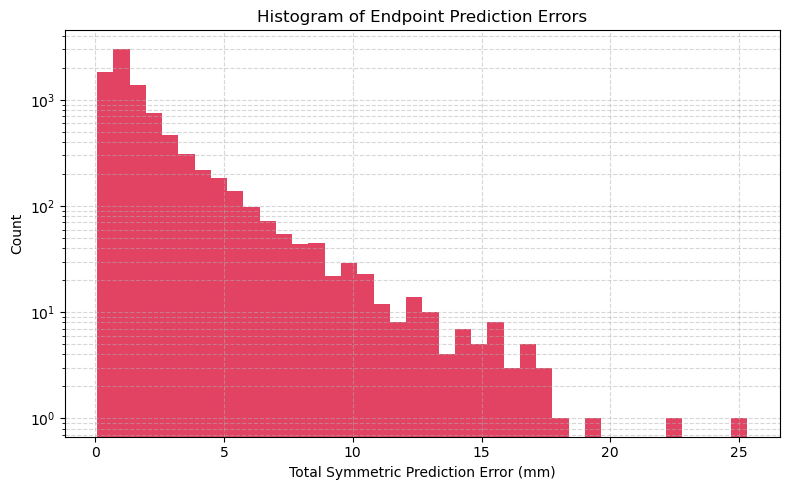

In [32]:
mean_error, failures, all_distances, all_preds, all_targets, per_endpoint_errors = evaluate_pionstop_model_mc_dropout(
    main_model, validation_dataset,
    batch_size=1, num_samples=6,
    failure_threshold=2.0, plot=True
)

In [33]:
def find_error_dist(a,b,split=False):
    """
    Find the error distance between two 2D endpoints.
    a and b should be of shape [2, 3] (2 endpoints, each with x, y, z)
    """
    d0 = np.linalg.norm(a[0] - b[0])
    d1 = np.linalg.norm(a[1] - b[1])
    d2 = np.linalg.norm(a[0] - b[1])
    d3 = np.linalg.norm(a[1] - b[0])
    dist = min(d0+d1, d2+d3)
    if not split:
        return dist
    if (d0 + d1) < (d2 + d3):
        return a[0]-b[0], a[1]-b[1]
    else:
        return a[0]-b[1], a[1]-b[0]

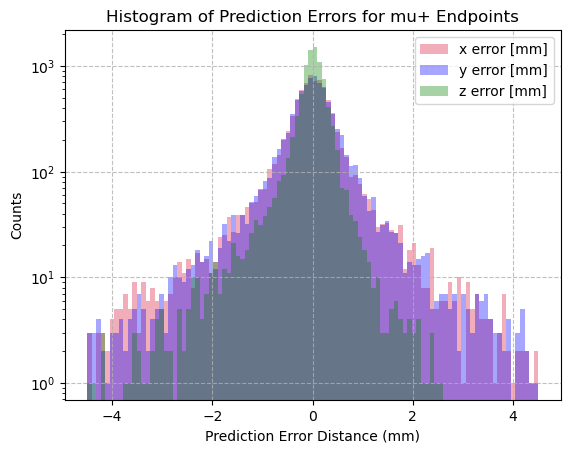

In [34]:
pDist = [find_error_dist(a,b)/2 for a, b in zip(all_preds, all_targets)]
pXYZ = np.array([find_error_dist(a,b,True) for a, b in zip(all_preds, all_targets)])
#plt.hist(pDist, bins=100, range=(0.0, 9.75), color='crimson', alpha=0.8)
plt.hist(pXYZ[:,1][:,0], bins=100, range=(-4.5,4.5), color='crimson', alpha=0.35, label='x error [mm]')
plt.hist(pXYZ[:,1][:,1], bins=100, range=(-4.5,4.5), color='blue', alpha=0.35, label='y error [mm]')
plt.hist(pXYZ[:,1][:,2], bins=100, range=(-4.5,4.5), color='green', alpha=0.35, label='z error [mm]')
plt.xlabel("Prediction Error Distance (mm)")
plt.ylabel("Counts")
plt.title("Histogram of Prediction Errors for mu+ Endpoints")
#plt.axvline(x=0.0553, color='black', linestyle='--', linewidth=1)
plt.yscale('log')
plt.grid(True, alpha=0.8, linestyle='--')
plt.legend()
plt.show()

In [35]:
print([fail[0] for fail in failures])

[1, 2, 4, 6, 11, 14, 16, 20, 24, 26, 37, 47, 49, 61, 62, 74, 75, 76, 78, 82, 86, 88, 99, 101, 102, 115, 117, 119, 120, 121, 127, 128, 139, 142, 146, 152, 154, 157, 158, 159, 174, 177, 181, 190, 193, 198, 200, 204, 205, 206, 210, 211, 212, 216, 219, 220, 230, 232, 234, 236, 244, 253, 257, 266, 271, 274, 275, 281, 283, 284, 286, 291, 292, 293, 295, 308, 309, 312, 314, 315, 319, 320, 322, 323, 332, 336, 344, 345, 346, 350, 352, 358, 360, 361, 364, 366, 370, 371, 372, 378, 380, 383, 384, 388, 397, 399, 406, 409, 412, 422, 424, 427, 431, 435, 436, 437, 441, 443, 453, 456, 463, 468, 469, 473, 478, 483, 488, 490, 491, 493, 499, 500, 504, 505, 512, 516, 522, 523, 524, 526, 531, 534, 535, 536, 542, 545, 546, 552, 557, 559, 560, 563, 567, 569, 571, 573, 576, 577, 580, 591, 592, 593, 594, 606, 607, 609, 612, 617, 618, 622, 624, 627, 628, 635, 640, 641, 643, 644, 647, 651, 654, 659, 660, 661, 662, 664, 665, 668, 670, 671, 674, 676, 679, 682, 687, 691, 698, 700, 701, 704, 713, 715, 718, 719, 727, 7

In [36]:
z_err = (all_preds-all_targets)[:,1][:,2]
print([i for i, e in enumerate(z_err) if abs(e) > 2])

[2, 5, 8, 9, 11, 24, 31, 33, 34, 38, 40, 43, 48, 59, 60, 61, 63, 64, 79, 80, 82, 83, 84, 92, 99, 105, 106, 107, 108, 116, 118, 131, 134, 136, 140, 141, 147, 152, 156, 159, 161, 163, 164, 168, 170, 171, 172, 178, 180, 182, 185, 186, 187, 191, 192, 195, 197, 201, 204, 215, 224, 226, 230, 231, 237, 243, 246, 249, 251, 256, 258, 261, 263, 265, 267, 268, 270, 272, 278, 289, 291, 295, 296, 299, 301, 303, 304, 307, 309, 310, 311, 312, 314, 316, 317, 325, 326, 327, 336, 339, 343, 347, 349, 351, 352, 356, 365, 369, 372, 374, 376, 377, 379, 386, 387, 394, 396, 399, 400, 401, 402, 403, 404, 405, 407, 413, 414, 415, 416, 418, 421, 426, 428, 431, 432, 434, 438, 440, 445, 451, 456, 458, 463, 464, 465, 466, 470, 474, 475, 481, 482, 485, 486, 489, 490, 492, 494, 496, 499, 502, 503, 506, 507, 508, 510, 511, 513, 517, 521, 527, 529, 531, 541, 544, 545, 548, 552, 554, 555, 556, 560, 566, 567, 570, 571, 572, 574, 578, 581, 582, 584, 585, 586, 587, 594, 599, 600, 609, 610, 612, 614, 615, 616, 619, 622, 626

[ -1.4477816 -12.416826    0.292089 ]


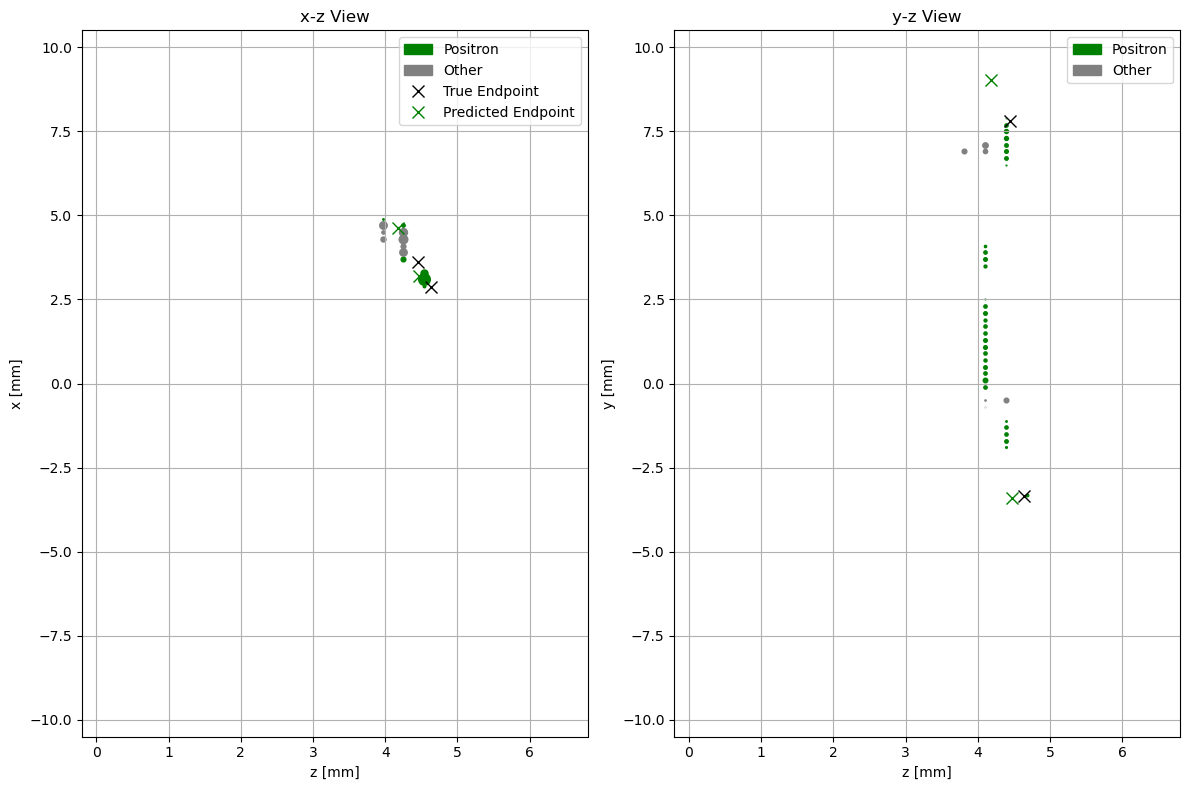

In [147]:
event_num = 109

fig, axs = plt.subplots(1, 2, figsize=(12, 8))

particle_colors = {
    1: ("red", "Pion"),
    2: ("blue", "Muon"),
    3: ("purple", "Pion + Muon"),
    4: ("green", "Positron"),
}
default_color = ("gray", "Other")

group = clean_groups[event_num+140000]
positions = group[:, :2]
energies = group[:, 3]
pdgs = group[:, 5].astype(int)
hViews = group[:, 2].astype(int)

recon_endpoints = all_preds[event_num]       # shape: [2, 3]
true_endpoints = all_targets[event_num]      # shape: [2, 3]

print(recon_endpoints[1] - recon_endpoints[0])
#print(true_endpoints[0] - recon_endpoints[0])
#print(true_endpoints[1] - recon_endpoints[1])

for i in range(2):  # 0 = x view, 1 = y view
    ax = axs[i]
    view_mask = (hViews == i)
    view_indices = np.where(view_mask)[0]

    h2D = positions[view_mask]
    hEs = energies[view_mask]
    hPDGs_view = pdgs[view_mask]

    colors = [particle_colors.get(pdg, default_color)[0] for pdg in hPDGs_view]

    for j, (x_or_y, z) in enumerate(h2D):
        ax.scatter(z, x_or_y, c=colors[j], s=100 * hEs[j])

    # Plot endpoints (true and predicted)
    for j in range(2):  # each endpoint
        ax.plot(
            true_endpoints[j, 2], true_endpoints[j, i],
            marker='x', color='black', markersize=8,
            label=f"True Endpoint {j}" if i == 0 else None
        )
        ax.plot(
            recon_endpoints[j, 2], recon_endpoints[j, i],
            marker='x', color='green', markersize=8,
            label=f"Predicted Endpoint {j}" if i == 0 else None
        )


    # Construct legend
    legend_patches = []
    seen_labels = set()
    for pdg in np.unique(hPDGs_view):
        color, label = particle_colors.get(pdg, default_color)
        if label not in seen_labels:
            legend_patches.append(mpatches.Patch(color=color, label=label))
            seen_labels.add(label)

    if i == 0:
        legend_patches += [
            Line2D([0], [0], marker='x', color='black', linestyle='None', markersize=8, label='True Endpoint'),
            Line2D([0], [0], marker='x', color='green', linestyle='None', markersize=8, label='Predicted Endpoint'),
        ]

    ax.legend(handles=legend_patches, loc='upper right')
    ax.set_xlabel("z [mm]")
    ax.set_ylabel("x [mm]" if i == 0 else "y [mm]")
    ax.set_title(f"{'x' if i == 0 else 'y'}-z View")
    ax.grid(True)
    ax.set_xlim(-0.2, 6.8)
    ax.set_ylim(-10.5, 10.5)

plt.tight_layout()
plt.show()

In [ ]:
torch.save(main_model.state_dict(), '/mnt/e/testML/endpoint_finder_ePlus_V3.pth')

: 

In [55]:
torch.save(main_model.state_dict(), '/mnt/e/testML/endpoint_finder_muPlus_V1.pth')

In [23]:
main_model = EndpointFinderGNN(in_channels=6, hidden_channels=64, num_blocks=2, dropout=0.05)
main_model.load_state_dict(torch.load('/mnt/e/testML/endpoint_finder_ePlus_V2.pth'))

/home/omar/miniconda3/envs/research/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'nn.glob.GlobalAttention' is deprecated, use 'nn.aggr.AttentionalAggregation' instead
  warnings.warn(out)


<All keys matched successfully>

In [135]:
import joblib
joblib.dump(mainTimeGroups, '/mnt/e/testML/timegroups1Hz.pkl', compress=3)

: 